# Overview

## Output Files:
- SQGDP9_US_2005_2022.csv
- Aon_US_Damage_2004_to_2022.csv
- Aon_US_Damage_2004_to_2022_dropped.csv
- rsmeans_wtavgs_st.csv
- nationwide_constr_spend_qtr.csv

## BEA Construction Data

### Input:
- SQGDP9_AK_2005_2022.csv
- SQGDP9_AL_2005_2022.csv
- ...
- SQGDP9_WV_2005_2022.csv
- SQGDP9_WY_2005_2022.csv

### Output:
- SQGDP9_US_2005_2022.csv

## AON Damages Data

### Input: 
- Aon Damages by Time Location and Amount 2004 to 2022.xlsx

### Output:  
- Aon_US_Damage_2004_to_2022.csv
- Aon_US_Damage_2004_to_2022_dropped.csv

## RSMeans Data

### Input:
- rsmeans.pkl

### Output:
- rsmeans.csv

## US Construction GDP Data

### Input:
- nationwide_constr_spend.xlsx

### Output:
- nationwide_constr_spend_qtr.csv

## Preliminaries

In [ ]:
# set to true to create output files again
create_output_files = False
chunk_size = 200000

In [ ]:
import pandas as pd
import numpy as np
import re
import glob
import os
import pickle
import datetime
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
from scipy.stats import rvs_ratio_uniforms
from sympy import *
import sympy
import scipy.stats as stats

### Files and Directories

In [ ]:
# Base
#base_dir = "./Rich"
base_dir = '/content/drive/MyDrive/environment'
out_dir = os.path.join(base_dir,"out2")

# FEMA
#fema_in_file = "HELP HELP.xlsx"
fema_in_file = "HELP HELP2.xlsx"
fema_fed_out_file = "fema_fed_by_month"     # .csv added later
fema_st_out_file = "fema_state_by_month"    # .csv added later
fema_tot_out_file = "fema_total_by_month"   # .csv added later

fema_err_dt1_out_file = "fema_err_start_date.csv"
fema_err_dt2_out_file = "fema_err_end_date.csv"
fema_err_dt2_lt_dt1_file = "fema_err_start_date_gt_end_date.csv"
fema_err_tot_spend = "fema_err_total_spend.csv"
fema_err_fed_spend = "fema_err_fed_spend.csv"
fema_err_st_spend = "fema_err_state_spend.csv"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Process FEMA

In [ ]:
dffema = None   # master set
dti = None
df = None       # chunk set
use_gaussian = True
cdfbins = 1000
cdftot = 1000000
cdf = None

In [ ]:
#def clean(save_date_errors=False,dates_only=False):
def clean():
    global dffema
    dffema["START YR"] = pd.to_numeric(dffema["START YR"], 
                                        errors='coerce').fillna(0).astype('int')
    dffema["START MO"] = pd.to_numeric(dffema["START MO"], 
                                        errors='coerce').fillna(0).astype('int')
    dffema["END YR"] = pd.to_numeric(dffema["END YR"], 
                                    errors='coerce').fillna(0).astype('int')
    dffema["END MO"] = pd.to_numeric(dffema["END MO"], 
                                    errors='coerce').fillna(0).astype('int')
    baddates = (dffema["END MO"]==0)
    dffema.loc[baddates,"END YR"] = dffema[baddates]["START YR"]
    dffema.loc[baddates,"END MO"] = dffema[baddates]["START MO"]

    dferr = dffema[pd.to_datetime(dffema["START MO"].astype(str) + " " \
                                    + dffema["START YR"].astype(str), 
                                    errors="coerce").isna()]
    if len(dferr) > 0:
        dferr.to_csv(os.path.join(base_dir,fema_err_dt1_out_file))

    dferr = dffema[pd.to_datetime(dffema["END MO"].astype(str) + " " \
                                    + dffema["END YR"].astype(str),
                                    errors="coerce").isna()]
    if len(dferr) > 0:
        dferr.to_csv(os.path.join(base_dir,fema_err_dt2_out_file))

    dferr = dffema[(pd.to_datetime(dffema['END YR'].astype(str) \
                                   + " "+dffema['END MO'].astype(str))) \
                   < (pd.to_datetime(dffema['START YR'].astype(str) \
                                     + " " + dffema['START MO'].astype(str)))]
    if len(dferr) > 0:
        dferr.to_csv(os.path.join(base_dir,fema_err_dt2_lt_dt1_file))

    dffema = dffema[pd.to_datetime(dffema["START MO"].astype(str) + \
                                    " " + dffema["START YR"].astype(str), 
                                    errors="coerce").notna()]
    dffema = dffema[pd.to_datetime(dffema["END MO"].astype(str) + \
                                    " " + dffema["END YR"].astype(str),
                                    errors="coerce").notna()]
    dffema = dffema[(pd.to_datetime(dffema['END YR'].astype(str) \
                                   + " "+dffema['END MO'].astype(str))) \
                   >= (pd.to_datetime(dffema['START YR'].astype(str) \
                                     + " " + dffema['START MO'].astype(str)))]

    dffema["TOTAL PROJECT SPEND"] = pd.to_numeric(dffema["TOTAL PROJECT SPEND"],
                                                    errors='coerce').fillna(0).astype('float').round(2)
    dffema["FED SPEND"] = pd.to_numeric(dffema["FED SPEND"], 
                                        errors='coerce').fillna(0).astype('float').round(2)
    dffema["STATE SPEND"] = pd.to_numeric(dffema["STATE SPEND"], 
                                            errors='coerce').fillna(0).astype('float').round(2)


In [ ]:
def create_dates_index():
    global dffema
    global dti
    dti = pd.date_range(start=pd.to_datetime(dffema["START MO"].astype(str) + \
                                            " " + dffema["START YR"].astype(str)).min(),
                        end=pd.to_datetime(dffema["END MO"].astype(str) + \
                                            " " + dffema["END YR"].astype(str),
                                            format="%m %Y").max()+MonthEnd(0),
                        freq='M').strftime("%Y-%m")

In [ ]:
def split_spending1(row,col_name):
    dt1 = pd.to_datetime(str(row["START MO"]) + " " + str(row["START YR"]))
    dt2 = max(pd.to_datetime(str(row["START MO"]) + \
                             " " + str(row["START YR"])),
              pd.to_datetime(str(row["END MO"]) + \
                             " " + str(row["END YR"]))) + MonthEnd(0)
    #print(row.index.tolist())
    if(dt1 != dt2):
      dtr = pd.date_range(start=dt1, end=dt2, freq='M').strftime("%Y-%m")
      if use_gaussian:
        #spend = int(row["FED SPEND"]*100)
        spend = int(row[col_name]*100)
        days = len(pd.date_range(start=dt1, end=dt2, freq='D'))
        #print(days)
        mu = days/2
        sigma = days/6
        a, b = (0 - mu) / sigma, ((days-1) - mu) / sigma
        seed = 47563
        rng = np.random.default_rng(seed)
        vals = stats.truncnorm.rvs(a,b,loc=mu,scale=sigma,size=spend,random_state=rng).round().astype(int)
        vals = np.bincount(vals)
        #print(len(vals))
        #print(len(dtr.tolist()))
        df = pd.DataFrame({"val":vals},index=pd.date_range(start=dt1, end=dt2, freq='D'))
        #print(len(df.groupby(df.index.strftime('%Y-%m')).sum().reset_index().val.tolist()))
        #row[dtr.tolist()] = ((df.groupby(df.index.strftime('%Y-%m')).sum().reset_index().val)/100).tolist()
        row[dtr.tolist()] = df.groupby(df.index.strftime('%Y-%m')).sum().reset_index().val.tolist()
        #print('......................')
      else:
        #print(dtr.tolist())
        dtrlst = dtr.tolist()
        row[dtrlst] = round(row[col_name]/len(dtrlst),2)
        # tmp = round(row[dtr.tolist()].sum(),2)
        # if tmp > row[col_name]:
        #     tmp = round(tmp-row[col_name],2)
        #     # reduce tails
        #     row[dtrlst[0]] -= round(tmp/2,2)
        #     if tmp > .01:
        #         row[dtrlst[-1]] -= round(tmp/2 + (0. if (int(tmp)*100)%2 == 0 else .01),2)
        # elif tmp < row[col_name]:
        #     # pad center
        #     row[dtrlst[int(len(dtrlst)/2)]] += round(row[col_name]-tmp,2)
    else:
      row[dt1.strftime("%Y-%m")] = row[col_name]
    #print(".....................")
    return row

In [ ]:
def split_spending(row,col_name):
    # dt1 = pd.to_datetime(str(row["START MO"]) + " " + str(row["START YR"]))
    # dt2 = max(pd.to_datetime(str(row["START MO"]) + \
    #                          " " + str(row["START YR"])),
    #           pd.to_datetime(str(row["END MO"]) + \
    #                          " " + str(row["END YR"]))) + MonthEnd(0)
    n = row["months"]
    if(n == 1):
        row["spend"] = row[col_name]
    else:
        i = row["mindex"]
        if use_gaussian:
            if n==0:
                print("zero in months column!")
                print(F"row: {row}")
                return row
            part = int(1/n)*cdfbins
            #print(F"i: {i} , part: {part}")
            if i == 0:
                row["spend"] = round((cdf[part - 1]/cdftot)*row[col_name],2)
            #elif i == n-1:
            #    row["spend"] = round(((cdf[cdfbins-1] \
            #                          - cdf[i*part - 1])/cdftot)*row[col_name],2)
            else:
                row["spend"] = round(((cdf[(i+1)*part-1] \
                                      - cdf[i*part-1])/cdftot)*row[col_name],2)
        else:
            row["spend"] = round(row[col_name]/n,2)
    return row

In [ ]:
def split_fed_spending(row):
    return split_spending(row,"FED SPEND")

In [ ]:
def split_state_spending(row):
    return split_spending(row,"STATE SPEND")

In [ ]:
def split_tot_spending(row):
    return split_spending(row,"TOTAL PROJECT SPEND")

In [ ]:
def build_gassian_prototype():
    global cdf
    seed = 47563
    rng = np.random.default_rng(seed)
    #days = 1000
    #spend = 1000000

    mu = cdfbins/2
    sigma = cdfbins/6
    
    a, b = (0 - mu) / sigma, ((cdfbins-1) - mu) / sigma
    
    #X = stats.truncnorm(0, days-1, loc=mu, scale=sigma)
    #stats.truncnorm(0, days-1, loc=mu, scale=sigma)
    cdf = stats.truncnorm.rvs(a,b,loc=mu,scale=sigma,
                              size=cdftot,random_state=rng).round().astype(int)
    _ = plt.hist(cdf,bins=np.arange(cdfbins))
    cdf = np.bincount(cdf)
    for i in np.arange(cdfbins):
         if i == 0:
             continue
         cdf[i] += cdf[i-1]
    #print(rng.random())
    #vals = np.clip(rng.normal(mu,sigma,spend).round().astype(int),0,days-1)
    #vals = np.clip(rng.normal(days/2,days/6,spend).round().astype(int),0,days-1)
    #vals = np.clip(np.random.gamma(40,.5,spend).round().astype(int),0,days-1)
    #print(np.bincount(vals))
    #prototype = np.bincount(prototype)
    #prototype = np.bincount(vals).sum()
    #$print(vals.sum())

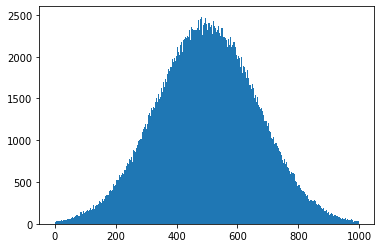

In [ ]:
build_gassian_prototype()

In [ ]:
#display(cdf)

In [ ]:
# def add_columns():
#   global df
#   global dti
#   if len(df) == 0:
#     return

#   df = df.reindex(df.columns.tolist()+dti.tolist(),fill_value=0.,axis=1)
#   #df = pd.concat([df,pd.DataFrame(columns=dti.tolist())])
#   #df[dti.tolist()] = df[dti.tolist()].astype(float)
#   #df[dti.tolist()] = 0.0


In [ ]:
dffema = pd.DataFrame(pd.read_excel(os.path.join(base_dir,fema_in_file),
                                    header=1,
                                    sheet_name='HELP',
                                    usecols=np.arange(12).tolist()))
headers = dffema.columns
#display(headers)
#display(dffema)
#display(dffema[dffema.index.isin([1,3,4])])
#display(dffema[dffema.index < 3])
#clean(True,True)
clean()
create_dates_index()
display(dffema)
dffema_len = len(dffema)
#dffema = dffema.reindex(dffema.columns.tolist()+dti.tolist(),
#                        fill_value=0.,axis=1)
# maintain copy for later
dffema_orig = dffema.copy()

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,1039431.28,0.00
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,1998.38,666.13
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,17185.70,5728.57
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,0.00,0.00
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,70000.00,0.00
5,PUBLIC ASSISTANCE,Tornado,Logan,OK,1999,5,1999,5,1,187500.00,187500.00,0.00
6,PUBLIC ASSISTANCE,Tornado,Oklahoma,OK,1999,5,1999,5,1,250000.00,250000.00,0.00
7,PUBLIC ASSISTANCE,Tornado,Statewide,OK,1999,5,1999,5,1,500000.00,500000.00,0.00
8,PUBLIC ASSISTANCE,Tornado,McClain,OK,1999,5,1999,5,1,562500.00,562500.00,0.00
9,PUBLIC ASSISTANCE,Tornado,Grady,OK,1999,5,1999,5,1,1000000.00,1000000.00,0.00


In [ ]:
#dffema = dffema_orig.copy()
# add range column (list of n months from start to end, formate YYYY-MM)
dt1 = pd.to_datetime(dffema["START MO"].astype(str) + " " \
                           + dffema["START YR"].astype(str))
dt2 = pd.to_datetime(dffema["END MO"].astype(str) + " " \
                           + dffema["END YR"].astype(str)) + MonthEnd(0)
dffema["range"] = [pd.date_range(a, b, freq='M').strftime("%Y-%m").tolist() for a, b in zip(dt1, dt2)]

# add months column (n, single number per row, not a list)
dffema["months"] = dffema["range"].apply(len)

# add mindex column (0 to n-1)
dffema["mindex"] = dffema["months"].apply(np.arange)

# add spend column (list of n 0.0's, placeholder for the calculated spend later
dffema["spend"] = dffema["months"].apply(np.zeros)

# drop all but the above 4 columns + index
dffema = dffema.drop(["FUND SOURCE","TYPE","COUNTY","STATE","START YR","START MO","END YR","END MO","NUMBER OF MONTHS"],axis=1)

# explode date, index and spend (each is a list with n elements)
dffema = dffema.explode(["range","mindex","spend"])
display(dffema)

,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND,range,months,mindex,spend
0,1039431.28,1039431.28,0.00,2005-09,1,0,0.0
1,2664.51,1998.38,666.13,2012-08,1,0,0.0
2,22914.27,17185.70,5728.57,2012-08,1,0,0.0
3,0.00,0.00,0.00,1999-05,1,0,0.0
4,70000.00,70000.00,0.00,1999-05,1,0,0.0
...,...,...,...,...,...,...,...
26,23079.68,20771.71,2307.97,2012-11,6,1,0.0
26,23079.68,20771.71,2307.97,2012-12,6,2,0.0
26,23079.68,20771.71,2307.97,2013-01,6,3,0.0
26,23079.68,20771.71,2307.97,2013-02,6,4,0.0


In [ ]:
#display(cdf)
dffema = dffema.apply(split_fed_spending,axis=1)
display(dffema)
# dffema.apply(split_fed_spending,
#              axis=1).to_csv(os.path.join(base_dir,fema_fed_out_file))
# dffema.apply(split_state_spending,
#              axis=1).to_csv(os.path.join(base_dir,fema_st_out_file))
# dffema.apply(split_tot_spending,
#              axis=1).to_csv(os.path.join(base_dir,fema_tot_out_file))

,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND,range,months,mindex,spend
0,1039431.28,1039431.28,0.00,2005-09,1,0,1039431.28
1,2664.51,1998.38,666.13,2012-08,1,0,1998.38
2,22914.27,17185.70,5728.57,2012-08,1,0,17185.70
3,0.00,0.00,0.00,1999-05,1,0,0.00
4,70000.00,70000.00,0.00,1999-05,1,0,70000.00
...,...,...,...,...,...,...,...
26,23079.68,20771.71,2307.97,2012-11,6,1,0.00
26,23079.68,20771.71,2307.97,2012-12,6,2,0.00
26,23079.68,20771.71,2307.97,2013-01,6,3,0.00
26,23079.68,20771.71,2307.97,2013-02,6,4,0.00


In [ ]:
#dffema[dffema["months"]==0]
#dffema_orig[dffema_orig.index==746870]
display(dffema_orig[(pd.to_datetime(dffema_orig['END YR'].astype(str)+" "+dffema_orig['END MO'].astype(str))) \
                    < (pd.to_datetime(dffema_orig['START YR'].astype(str)+" "+dffema_orig['START MO'].astype(str)))])

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND
746870,HAZARD MITIGATION ASSIST,HMGP,HANCOCK,Maine,2002,8,2002,2,NaN,5210.00,3908.00,1302.00
748021,HAZARD MITIGATION ASSIST,HMGP,YAVAPAI,Arizona,2004,4,2003,11,NaN,32027.00,24020.00,8007.00
748164,HAZARD MITIGATION ASSIST,HMGP,WASHINGTON,Vermont,2004,6,2002,11,NaN,1040.00,780.00,260.00
748599,HAZARD MITIGATION ASSIST,HMGP,NEWPORT NEWS (CITY),Virginia,2005,1,2003,7,NaN,210775.00,124117.00,86658.00
748600,HAZARD MITIGATION ASSIST,HMGP,SOUTHAMPTON,Virginia,2005,1,2003,8,NaN,146510.00,109883.00,36627.00
...,...,...,...,...,...,...,...,...,...,...,...,...
768421,HAZARD MITIGATION ASSIST,HMGP,BALTIMORE,Maryland,2021,1,2020,1,NaN,350030.28,262527.00,87503.28
768422,HAZARD MITIGATION ASSIST,HMGP,RALEIGH,West Virginia,2021,1,2020,1,NaN,419033.09,314274.82,104758.27
768504,HAZARD MITIGATION ASSIST,HMGP,KANAWHA,West Virginia,2021,2,2020,3,NaN,186125.00,139593.75,46531.25
768945,HAZARD MITIGATION ASSIST,HMGP,DODDRIDGE; HARRISON; MARION; MONONGALIA; PREST...,West Virginia,2021,6,2019,5,NaN,71687.58,53765.69,17921.89


In [ ]:
df = pd.DataFrame({
    #"ID":[0,1,2,3,4,5],
    "START MO":[10,11,7,3,3,10],
    "START YR":[2010,2010,2018,2017,2018,2020],
    "END MO": [10,12,7,8,4,12],
    "END YR":[2010,2010,2018,2017,2019,2020],
    "TOTAL PROJECT SPEND":[47,28,3888,20,578,1988]})
dforig = df.copy()
dt1 = pd.to_datetime(df["START MO"].astype(str) + " " \
                           + df["START YR"].astype(str))
dt2 = pd.to_datetime(df["END MO"].astype(str) + " " \
                           + df["END YR"].astype(str)) + MonthEnd(0)
#display(df)
#display(dt1)
#display(dt2)
#display([{a:b} for a,b in zip(dt1,dt2)])
df["DATE_RANGE"] = [pd.date_range(a, b, freq='M').strftime("%Y-%m").tolist() for a, b in zip(dt1, dt2)]
df["DATE_RANGE_DATA"] = [[1. for x in pd.date_range(a, b, freq='M').strftime("%Y-%m").tolist()] for a, b in zip(dt1, dt2)]
df["DATE_RANGE_COUNT"] = [[1. for x in pd.date_range(a, b, freq='M').strftime("%Y-%m").tolist()] for a, b in zip(dt1, dt2)]

#df["DATE_RANGE_DATA"] = df["DATE_RANGE_DATA"].multipy(df["TOTAL PROJECT SPEND"])
#display(pd.Series(df["DATE_RANGE_DATA"]).multipy(pd.Series(df["TOTAL PROJECT SPEND"])))
#display(df["START MO"]*df["START YR"])
#display(df["START MO"]*[1,2])
#display(df)
df = df.explode(["DATE_RANGE","DATE_RANGE_DATA"])
df["DATE_RANGE_DATA"] *= df["TOTAL PROJECT SPEND"]
display(df)
#display(df.stack())
#display(df.set_index("DATE_RANGE").unstack())
#df = df.set_index(['DATE_RANGE'], append=True)
#df = df.set_index(["START MO","START YR","END MO","END YR"], append=True)
#display(df)
df = df.pivot(values="DATE_RANGE_DATA",columns="DATE_RANGE")
#df = df.pivot(values="DATE_RANGE_DATA",index=["START MO","START YR","END MO","END YR"],columns="DATE_RANGE",)
#df = df.pivot(values="DATE_RANGE_DATA",index=df.index,columns="DATE_RANGE")
df.columns.name = ""
#display(df.index)
#display(dforig)
display(df)
#display(dforig.join(df))
#display(df.index)
#display(df.columns.name)
#display(df.columns.names)
#display(df.unstack())
#display(df.pivot(index="DATE_RANGE_DATA", columns="DATE_RANGE"))

,START MO,START YR,END MO,END YR,TOTAL PROJECT SPEND,DATE_RANGE,DATE_RANGE_DATA,DATE_RANGE_COUNT
0,10,2010,10,2010,47,2010-10,47.0,[1.0]
1,11,2010,12,2010,28,2010-11,28.0,"[1.0, 1.0]"
1,11,2010,12,2010,28,2010-12,28.0,"[1.0, 1.0]"
2,7,2018,7,2018,3888,2018-07,3888.0,[1.0]
3,3,2017,8,2017,20,2017-03,20.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
3,3,2017,8,2017,20,2017-04,20.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
3,3,2017,8,2017,20,2017-05,20.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
3,3,2017,8,2017,20,2017-06,20.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
3,3,2017,8,2017,20,2017-07,20.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
3,3,2017,8,2017,20,2017-08,20.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"


,2010-10,2010-11,2010-12,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2018-03,...,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2020-10,2020-11,2020-12
0,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,28.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,20.0,20.0,20.0,20.0,20.0,20.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,578.0,...,578.0,578.0,578.0,578.0,578.0,578.0,578.0,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988.0,1988.0,1988.0


In [ ]:
#base_dir = '/content/drive/MyDrive/environment'
#print(os.path.join(base_dir,fema_in_file))
#!head /content/drive/MyDrive/environment/HELP\ HELP2.xlsx
# 950547 rows in file
#skip = 800000 # skipping starts *after* the header, do not need to account for lines prior
chunk_size = 200000
#chunk_size = 2
#chunk_size = 1000000
n = 0

if dffema_len > 0:
    while True:
        #dffema = pd.DataFrame(pd.read_excel(os.path.join(base_dir,fema_in_file),
        #                                    header=None,sheet_name='HELP',
        #                                    usecols=np.arange(12).tolist(),
        #                                    names=headers,
        #                                    nrows=chunk_size,
        #                                    skiprows=startskip+chunk_size*n))
        df = dffema[(dffema.index >= n*chunk_size) \
                    & (dffema.index < (n+1)*chunk_size)].copy()
        #display(df)
        if len(df) > 0:
            #add_columns()
            #df = df.reindex(df.columns.tolist()+dti.tolist(),fill_value=0.,axis=1)
            dt1 = pd.to_datetime(df["START MO"].astype(str) + " " \
                                + df["START YR"].astype(str))
            dt2 = pd.to_datetime(df["END MO"].astype(str) + " " \
                                + df["END YR"].astype(str)) + MonthEnd(0)
            #dt1 = pd.Series([pd.to_datetime("10 2018"),pd.to_datetime()])
            # dr = pd.Series([pd.date_range(a, b, freq='M').strftime("%Y-%m").tolist() for a, b in zip(dt1, dt2)])
            # drd = pd.Series([[1. for x in pd.date_range(a, b, freq='M').strftime("%Y-%m").tolist()] for a, b in zip(dt1, dt2)])
            # display(dr.head())
            # display(drd.head())
            dr = [pd.date_range(a, b, freq='M').strftime("%Y-%m").tolist() for a, b in zip(dt1, dt2)]
            drd = [[1. for x in pd.date_range(a, b, freq='M').strftime("%Y-%m").tolist()] for a, b in zip(dt1, dt2)]
            display(df.head())
            dforig = df
            df["DATE_RANGE"] = dr
            df["DATE_RANGE_DATA"] = drd
            print("DATE_RANGE and DATE_RANGE_DATA added")
            display(df.head())
            # df["DATE_RANGE"] = \
            #   pd.Series([pd.date_range(a, b, freq='M').strftime("%Y-%m").tolist() for a, b in zip(dt1, dt2)])
            # df["DATE_RANGE_DATA"] = \
            #   pd.Series([[1. for x in pd.date_range(a, b, freq='M').strftime("%Y-%m").tolist()] for a, b in zip(dt1, dt2)])
            df = df.explode(["DATE_RANGE","DATE_RANGE_DATA"])
            df = df.pivot(values="DATE_RANGE_DATA",columns="DATE_RANGE")
            df.columns.name = ""
            display(df.head())
            display(dforig.join(df).head())

            #df['DATE_RANGE'] = list(map(lambda x, y: pd.date_range(start=x, end=y),
            #                            dt1, dt2))
            #display([x for a, b in zip(dt1, dt2) \
            #         for x in pd.date_range(a, b, freq='M').strftime("%Y-%m").tolist()][:5])
            #display(dt2)
            #display(dt1)
            #print(F"{dt1} - {dt2}")
            #display(pd.date_range(start=dt1,end=dt2,freq='M'))
        #      display(pd.date_range(start=dt1,end=dt2,
        #                            freq='M').strftime("%Y-%m").tolist())
        #      df["DATE_RANGE"] = pd.date_range(start=dt1,
        #                                       end=dt2,
        #                                       freq='M').strftime("%Y-%m").tolist()
            #df[df["DATE_RANGE"]] = 1.
            #display(df["DATE_RANGE"].head())
            #df.head(1).to_csv(os.path.join(base_dir,F"{fema_tot_out_file}_{n+1}.csv"))
            # df.apply(split_fed_spending,
            #          axis=1).to_csv(os.path.join(base_dir,
            #                                      F"{fema_fed_out_file}_{n+1}.csv"))
            # df.apply(split_state_spending,
            #          axis=1).to_csv(os.path.join(base_dir,
            #                                      F"{fema_st_out_file}_{n+1}.csv"))
            # df.apply(split_tot_spending,
            #          axis=1).to_csv(os.path.join(base_dir,
            #                                      F"{fema_tot_out_file}_{n+1}.csv"))

        #print(F"iteration {n+1}")
        #clean()
        #display(df)
        #print(len(df))
#  if len(df) < chunk_size:
#    break
        print(F"iteration {n+1}: {len(df)} records read")
        #display(df)
        n += 1
        if n*chunk_size > (dffema_len-1):
            break

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,1039431.28,0.00
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,1998.38,666.13
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,17185.70,5728.57
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,0.00,0.00
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,70000.00,0.00


DATE_RANGE and DATE_RANGE_DATA added


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND,DATE_RANGE,DATE_RANGE_DATA
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,1039431.28,0.00,[2005-09],[1.0]
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,1998.38,666.13,[2012-08],[1.0]
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,17185.70,5728.57,[2012-08],[1.0]
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,0.00,0.00,[1999-05],[1.0]
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,70000.00,0.00,[1999-05],[1.0]


,1999-01,1999-02,1999-03,1999-04,1999-05,2005-09,2010-10,2010-11,2010-12,2011-01,2011-02,2012-08,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2010-12,2011-01,2011-02,2012-08,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


iteration 1: 27 records read


In [ ]:
#display(dffema)

In [ ]:
display(dffema)

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005.0,9,2005.00,9.0,1.0,1039431.28,1039431.28,0
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012.0,8,2012.00,8.0,1.0,2664.51,1998.38,666.13
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012.0,8,2012.00,8.0,1.0,22914.27,17185.7,5728.57
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999.0,5,1999.00,5.0,1.0,$-,$-,0
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999.0,5,1999.00,5.0,1.0,70000,70000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
950542,HOUSING ASSISTANCE RENTERS,NaN,53216,WI,2010.0,8,3361725.14,NaN,NaN,,3361725.14,NaN
950543,HOUSING ASSISTANCE RENTERS,NaN,53218,WI,2010.0,8,3753216.85,NaN,NaN,,3753216.85,NaN
950544,HOUSING ASSISTANCE RENTERS,NaN,53209,WI,2010.0,8,4084102.26,NaN,NaN,,4084102.26,NaN
950545,HOUSING ASSISTANCE RENTERS,NaN,53206,WI,2010.0,8,4770400.99,NaN,NaN,,4770400.99,NaN


In [ ]:
#print(dffema["FED SPEND"])
#dffema["FED SPEND"] = dffema["FED SPEND"].str.strip()
#print(dffema["FED SPEND"])
#dffema["FED SPEND"] = dffema["FED SPEND"].replace('$','')
#print(dffema["FED SPEND"])
#dffema["FED SPEND"] = dffema["FED SPEND"].str.replace('$','')
#dffema["STATE SPEND"] = dffema["STATE SPEND"].str.replace('$','')
#dffema["TOTAL PROJECT SPEND"] = dffema["TOTAL PROJECT SPEND"].str.replace('$','')
#display(dffema)
dffema["TOTAL PROJECT SPEND"] = pd.to_numeric(dffema["TOTAL PROJECT SPEND"], errors='coerce').fillna(0).astype('float').round(2)
dffema["FED SPEND"] = pd.to_numeric(dffema["FED SPEND"], errors='coerce').fillna(0).astype('float').round(2)
dffema["STATE SPEND"] = pd.to_numeric(dffema["STATE SPEND"], errors='coerce').fillna(0).astype('float').round(2)
dffema["START YR"] = pd.to_numeric(dffema["START YR"], errors='coerce').fillna(0).astype('int')
dffema["START MO"] = pd.to_numeric(dffema["START MO"], errors='coerce').fillna(0).astype('int')
dffema["END YR"] = pd.to_numeric(dffema["END YR"], errors='coerce').fillna(0).astype('int')
dffema["END MO"] = pd.to_numeric(dffema["END MO"], errors='coerce').fillna(0).astype('int')

In [ ]:
#dfemacpy = dffema.copy()

In [ ]:
#dffema = dfemacpy.copy()

In [ ]:
# if total project spend == 0, set equal to fed spend + state spend
#dffema[(dffema["FED SPEND"] + dffema["STATE SPEND"]).round(2) != dffema["TOTAL PROJECT SPEND"]]
adjust = (dffema["TOTAL PROJECT SPEND"] == 0.0) & ((dffema["FED SPEND"] > 0.0) | (dffema["STATE SPEND"] > 0.0))
#display(dffema[(dffema["TOTAL PROJECT SPEND"] == 0.0) & ((dffema["FED SPEND"] > 0.0) | (dffema["STATE SPEND"] > 0.0))])
dffema.loc[adjust,"TOTAL PROJECT SPEND"] = dffema[adjust]["FED SPEND"] + dffema[adjust]["STATE SPEND"]
display(dffema[adjust]["TOTAL PROJECT SPEND"])
# if total projct spend == 0, flag

5711      0.01
5712      0.01
19149     0.01
19746     0.01
30294     0.01
          ... 
193748    0.01
193749    0.01
193750    0.01
198742    0.01
199341    0.01
Name: TOTAL PROJECT SPEND, Length: 82, dtype: float64

In [ ]:
# assign end mo/yr to start mo/yr if end mo == 0
baddates = (dffema["END MO"]==0)
#display(baddates)
dffema.loc[baddates,"END YR"] = dffema[baddates]["START YR"]
dffema.loc[baddates,"END MO"] = dffema[baddates]["START MO"]
#dffema[dffema["END MO"]<1 & dffema["END MO"]>12]["END MO"] = dffema[dffema["END MO"]<1 & dffema["END MO"]>12]["START MO"]
#dffema[dffema["END YR"]<1 & dffema["END MO"]>12]["END MO"] = dffema[dffema["END MO"]<1 & dffema["END MO"]>12]["START YR"]
#baddates = ((dffema["END MO"]<1) | (dffema["END MO"]>12))
#display(dffema[(dffema["END MO"]<1) | (dffema["END MO"]>12)])
display(dffema[baddates])
#print(dffema["FED SPEND"])
#dffema["FED SPEND"] = dffema["FED SPEND"].replace('-','')
#dffema["FED SPEND"] = dffema["FED SPEND"].fillna(0).astype(float).round(2)

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND


In [ ]:
#help(pd.read_excel)
display(dffema)

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,1039431.28,0.00
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,1998.38,666.13
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,17185.70,5728.57
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,0.00,0.00
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,70000.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,PUBLIC ASSISTANCE,Severe Storm,Highland,OH,2008,10,2009,1,3,23480.70,17610.53,5870.17
199996,PUBLIC ASSISTANCE,Severe Storm,Montgomery,OH,2008,10,2009,1,3,37286.02,27964.52,9321.50
199997,PUBLIC ASSISTANCE,Severe Storm,Butler,OH,2008,10,2009,1,3,41855.64,31391.73,10463.91
199998,PUBLIC ASSISTANCE,Severe Storm,Knox,OH,2008,10,2009,1,3,56760.49,42570.37,14190.12


In [ ]:
# capture start date errors
dferr = dffema[pd.to_datetime(dffema["START MO"].astype(str) + " " + dffema["START YR"].astype(str), errors="coerce").isna()]
display(dferr)

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND


In [ ]:
# save start date errors for reference, these will not be included in final results
dferr.to_csv(os.path.join(base_dir,fema_err_dt1_out_file))

In [ ]:
# capture end date errors
dferr = dffema[pd.to_datetime(dffema["END MO"].astype(str) + " " + dffema["END YR"].astype(str), errors="coerce").isna()]
display(dferr)

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND


In [ ]:
# save end date errors for reference, these will not be included in final results
dferr.to_csv(os.path.join(base_dir,fema_err_dt2_out_file))

In [ ]:
# remove start date and end date errors
dffema = dffema[pd.to_datetime(dffema["START MO"].astype(str) + " " + dffema["START YR"].astype(str), errors="coerce").notna()]
dffema = dffema[pd.to_datetime(dffema["END MO"].astype(str) + " " + dffema["END YR"].astype(str), errors="coerce").notna()]
display(dffema)

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,1039431.28,0.00
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,1998.38,666.13
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,17185.70,5728.57
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,0.00,0.00
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,70000.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,PUBLIC ASSISTANCE,Severe Storm,Highland,OH,2008,10,2009,1,3,23480.70,17610.53,5870.17
199996,PUBLIC ASSISTANCE,Severe Storm,Montgomery,OH,2008,10,2009,1,3,37286.02,27964.52,9321.50
199997,PUBLIC ASSISTANCE,Severe Storm,Butler,OH,2008,10,2009,1,3,41855.64,31391.73,10463.91
199998,PUBLIC ASSISTANCE,Severe Storm,Knox,OH,2008,10,2009,1,3,56760.49,42570.37,14190.12


In [ ]:
#import numpy as np
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
from scipy.stats import rvs_ratio_uniforms
from sympy import *
import sympy
import scipy.stats as stats
#from scipy.stats import truncnorm

In [ ]:
# seed = 47563
# rng = np.random.default_rng(seed)
# days = 90
# spend = 500000
# mu = days/2
# sigma = days/6

# a, b = (0 - mu) / sigma, ((days-1) - mu) / sigma

# #X = stats.truncnorm(0, days-1, loc=mu, scale=sigma)
# #stats.truncnorm(0, days-1, loc=mu, scale=sigma)
# vals = stats.truncnorm.rvs(a,b,loc=mu,scale=sigma,size=spend,random_state=rng).round().astype(int)

# #print(rng.random())
# #vals = np.clip(rng.normal(mu,sigma,spend).round().astype(int),0,days-1)
# #vals = np.clip(rng.normal(days/2,days/6,spend).round().astype(int),0,days-1)
# #vals = np.clip(np.random.gamma(40,.5,spend).round().astype(int),0,days-1)
# print(np.bincount(vals))
# np.bincount(vals).sum()
# #$print(vals.sum())

In [ ]:
# _ = plt.hist(vals,bins=np.arange(days))

In [ ]:
# #from pandas.tseries.offsets import MonthEnd

# month1, year1 = 2, 2011
# month2, year2 = 3, 2015
# #print(pd.to_datetime(f"{month1} {year1}") + MonthEnd(0))
# print(pd.to_datetime(f"{month2} {year2}") + MonthEnd(0))
# dt2 = pd.to_datetime(f"{month2} {year2}") + MonthEnd(0)
# #f"{year}-{month}-1"
# #print(pd.Period(f"{month1} {year1}").daysinmonth)
# #print(pd.Period(f"{year1}-{month1}-1").daysinmonth)
# #print(pd.date_range(start='2019-11-22', periods=10, freq='D').to_period('M').value_counts())
# print(len(pd.date_range(start=f"{month1} {year1}", end=dt2, freq='D')))

In [ ]:
# step 1: add column for # of days in the specified months
# step 2: add columns for mu and sigma
# step 3: add columns for a and b
# step 4: add column for normal/gamma/other distribution over # of days (list with len == # days)
# step 5: add column for number of days for each month in range (list with len == # months)
# step 6: add column for month/year values (adds dist. vals from step 4 for # days/month in step 5)
#         (list of total month/year costs with len == # months)
# step 7: add column for offset to align start month/year with month/year column
# step 8: update the values in columns starting at the offset calcuated in step 7 with the 
#         values created in step 6 (not sure how to do this, but maybe "apply" method?)
# step 9: drop the columns added in steps 1-7
# step 10: create column that totals the month/year columns
# step 11: write any lines (ideally, including line number) to an error file

In [ ]:
#dffemacopy = dffema.copy()

In [ ]:
#dffema = dffemacopy.copy()

In [ ]:
#display(dffema)
#len(dffema.columns)
#help(dffema.reindex)
use_gaussian = False

In [ ]:
# dt1 = pd.to_datetime("2 2018")
# dt2 = pd.to_datetime("5 2019") + MonthEnd(0)
# days = len(pd.date_range(start=dt1, end=dt2, freq='D'))
# print(days)
# print(sum(pd.date_range(start=dt1, end=dt2, freq='M').daysinmonth))
# #pd.date_range(start=dt1, end=dt2, freq='D')
# a = np.arange(days)
# pd.date_range(start=dt1, end=dt2, freq='M').daysinmonth

# dr = pd.date_range(start=dt1, end=dt2, freq='D')
# mr = pd.date_range(start=dt1, end=dt2, freq='M')

# df = pd.DataFrame({"val":a},index=dr)
# #df.index.name = "day"
# display(df.index)
# df = df.groupby(df.index.strftime('%Y-%m')).sum().reset_index()
# #df.groupby(index.dt.strftime('%Y-%m')).sum().reset_index()
# df.val.tolist()
# #df.index

In [ ]:
# I think the best way to handle this is to create a start date and end date column, coercing errors
# drop all rows with invalid dates? Not sure.

#dffema = dffema[(dffema["START MO"]<=12) & (dffema["START MO"]>=1)]
#display(dffema[(dffema["START MO"]>12) | (dffema["START MO"]<1)])

In [ ]:
#dffema = dffemacopy.copy()
# add columns for all dates covered
#date_col_offset = len(dffema.columns)

#dti = pd.date_range(
#    start = pd.to_datetime(dffema["START MO"].astype(str) + " " + dffema["START YR"].astype(str)).min(),
#    end = max(pd.to_datetime(dffema["START MO"].astype(str) + " " + dffema["START YR"].astype(str)).max(),
#               pd.to_datetime(dffema["END MO"].astype(str) + " " + dffema["END YR"].astype(str)).max()),
#    freq='M').strftime("%Y-%m")

firstdate = pd.to_datetime(dffema["START MO"].astype(str) + " " + dffema["START YR"].astype(str)).min()
#lastdate = max(pd.to_datetime(dffema["START MO"].astype(str) + " " + dffema["START YR"].astype(str)).max(),
#               pd.to_datetime(dffema["END MO"].astype(str) + " " + dffema["END YR"].astype(str)).max())
#display(firstdate)
#display(lastdate)
#dti = pd.date_range(start=firstdate,end=lastdate,freq='M')
#dti = dti.strftime("%Y-%m")
# print(firstdate)
# print(pd.to_datetime(dffema["START MO"].astype(str) + 
#                                            " " + dffema["START YR"].astype(str)).max()+MonthEnd(0))
# print(pd.to_datetime(dffema["END MO"].astype(str) + 
#                                            " " + dffema["END YR"].astype(str)).max()+MonthEnd(0))
# print(max(pd.to_datetime(dffema["START MO"].astype(str) + 
#                                            " " + dffema["START YR"].astype(str)).max()+MonthEnd(0),
#                             pd.to_datetime(dffema["END MO"].astype(str) + 
#                                            " " + dffema["END YR"].astype(str)).max()+MonthEnd(0)))
dti = pd.date_range(start=firstdate,
                    end=max(pd.to_datetime(dffema["START MO"].astype(str) + 
                                           " " + dffema["START YR"].astype(str),format="%m %Y").max()+MonthEnd(0),
                            pd.to_datetime(dffema["END MO"].astype(str) + 
                                           " " + dffema["END YR"].astype(str),format="%m %Y").max()+MonthEnd(0)),
                    freq='M').strftime("%Y-%m")

display(dti)
#display(dti[5])
#display(df.columns.tolist() + dti.tolist())
dffema = dffema.reindex(dffema.columns.tolist()+dti.tolist(),fill_value=0,axis=1)
dffema[dti.tolist()] = dffema[dti.tolist()].astype(float)
#dffema[dti.tolist()] = dffema[dti.tolist()].astype(int)

Index(['1998-08', '1998-09', '1998-10', '1998-11', '1998-12', '1999-01',
       '1999-02', '1999-03', '1999-04', '1999-05',
       ...
       '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06',
       '2022-07', '2022-08', '2022-09', '2022-10'],
      dtype='object', length=291)

In [ ]:
display(dffema)

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,PUBLIC ASSISTANCE,Severe Storm,Highland,OH,2008,10,2009,1,3,23480.70,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199996,PUBLIC ASSISTANCE,Severe Storm,Montgomery,OH,2008,10,2009,1,3,37286.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199997,PUBLIC ASSISTANCE,Severe Storm,Butler,OH,2008,10,2009,1,3,41855.64,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199998,PUBLIC ASSISTANCE,Severe Storm,Knox,OH,2008,10,2009,1,3,56760.49,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
dffemafed = dffema.apply(split_fed_spending,axis=1)
dffemastate = dffema.apply(split_state_spending,axis=1)
dffematotal = dffema.apply(split_tot_spending,axis=1)
#dffema.apply(np.sqrt,axis=1)
#dffema = dffema.apply(split_spending,axis=1)
#dffema["2012-05"]
display(dffemafed)
display(dffemastate)
display(dffematotal)
#display(dffema["FED SPEND"])

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,...,0.0,0.0,1998.38,0.0,0.00,0.00,0.00,0.00,0.00,0.00
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,...,0.0,0.0,17185.70,0.0,0.00,0.00,0.00,0.00,0.00,0.00
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
5,PUBLIC ASSISTANCE,Tornado,Logan,OK,1999,5,1999,5,1,187500.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
6,PUBLIC ASSISTANCE,Tornado,Oklahoma,OK,1999,5,1999,5,1,250000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
7,PUBLIC ASSISTANCE,Tornado,Statewide,OK,1999,5,1999,5,1,500000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
8,PUBLIC ASSISTANCE,Tornado,McClain,OK,1999,5,1999,5,1,562500.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
9,PUBLIC ASSISTANCE,Tornado,Grady,OK,1999,5,1999,5,1,1000000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,...,0.0,0.0,666.13,0.0,0.00,0.00,0.00,0.00,0.00,0.00
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,...,0.0,0.0,5728.57,0.0,0.00,0.00,0.00,0.00,0.00,0.00
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
5,PUBLIC ASSISTANCE,Tornado,Logan,OK,1999,5,1999,5,1,187500.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
6,PUBLIC ASSISTANCE,Tornado,Oklahoma,OK,1999,5,1999,5,1,250000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
7,PUBLIC ASSISTANCE,Tornado,Statewide,OK,1999,5,1999,5,1,500000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
8,PUBLIC ASSISTANCE,Tornado,McClain,OK,1999,5,1999,5,1,562500.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
9,PUBLIC ASSISTANCE,Tornado,Grady,OK,1999,5,1999,5,1,1000000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,...,0.0,0.0,2664.51,0.0,0.00,0.00,0.00,0.00,0.00,0.00
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,...,0.0,0.0,22914.27,0.0,0.00,0.00,0.00,0.00,0.00,0.00
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
5,PUBLIC ASSISTANCE,Tornado,Logan,OK,1999,5,1999,5,1,187500.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
6,PUBLIC ASSISTANCE,Tornado,Oklahoma,OK,1999,5,1999,5,1,250000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
7,PUBLIC ASSISTANCE,Tornado,Statewide,OK,1999,5,1999,5,1,500000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
8,PUBLIC ASSISTANCE,Tornado,McClain,OK,1999,5,1999,5,1,562500.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
9,PUBLIC ASSISTANCE,Tornado,Grady,OK,1999,5,1999,5,1,1000000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
#display(dti)
#dffema[dti.tolist()].sum(axis=1)
dffemafed["Sanity"] = round(dffemafed[dti.tolist()].sum(axis=1),2)
dffemastate["Sanity"] = round(dffemastate[dti.tolist()].sum(axis=1),2)
dffematotal["Sanity"] = round(dffematotal[dti.tolist()].sum(axis=1),2)
#display(dffema)

display(dffemafed[dffemafed["Sanity"]!=dffemafed["FED SPEND"]][["Sanity","FED SPEND"]])
display(dffemastate[dffemastate["Sanity"]!=dffemastate["STATE SPEND"]][["Sanity","STATE SPEND"]])
display(dffematotal[dffematotal["Sanity"]!=dffematotal["TOTAL PROJECT SPEND"]][["Sanity","TOTAL PROJECT SPEND"]])
#display(dffema["Sanity"])
#display(dffema["FED SPEND"])

,Sanity,FED SPEND


,Sanity,STATE SPEND


,Sanity,TOTAL PROJECT SPEND


In [ ]:
display(dffema)

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,Sanity
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1039431.28
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,...,0.0,1998.38,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1998.38
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,...,0.0,17185.70,0.0,0.00,0.00,0.00,0.00,0.00,0.00,17185.70
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,70000.00
5,PUBLIC ASSISTANCE,Tornado,Logan,OK,1999,5,1999,5,1,187500.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,187500.00
6,PUBLIC ASSISTANCE,Tornado,Oklahoma,OK,1999,5,1999,5,1,250000.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,250000.00
7,PUBLIC ASSISTANCE,Tornado,Statewide,OK,1999,5,1999,5,1,500000.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,500000.00
8,PUBLIC ASSISTANCE,Tornado,McClain,OK,1999,5,1999,5,1,562500.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,562500.00
9,PUBLIC ASSISTANCE,Tornado,Grady,OK,1999,5,1999,5,1,1000000.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1000000.00


In [ ]:
dffemafed.to_csv(os.path.join(base_dir,fema_fed_out_file))
dffemastate.to_csv(os.path.join(base_dir,fema_st_out_file))
dffematotal.to_csv(os.path.join(base_dir,fema_tot_out_file))

In [ ]:
row_sum = dffemafed.loc[:,dti.tolist()].sum()
dffemafed.loc['Total'] = row_sum
dffemafed.fillna('')
display(dffemafed)

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,Sanity
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005.0,9.0,2005.0,9.0,1.0,1039431.28,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1039431.28
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012.0,8.0,2012.0,8.0,1.0,2664.51,...,0.0,1998.38,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1998.38
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012.0,8.0,2012.0,8.0,1.0,22914.27,...,0.0,17185.70,0.0,0.00,0.00,0.00,0.00,0.00,0.00,17185.70
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999.0,5.0,1999.0,5.0,1.0,0.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999.0,5.0,1999.0,5.0,1.0,70000.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,70000.00
5,PUBLIC ASSISTANCE,Tornado,Logan,OK,1999.0,5.0,1999.0,5.0,1.0,187500.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,187500.00
6,PUBLIC ASSISTANCE,Tornado,Oklahoma,OK,1999.0,5.0,1999.0,5.0,1.0,250000.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,250000.00
7,PUBLIC ASSISTANCE,Tornado,Statewide,OK,1999.0,5.0,1999.0,5.0,1.0,500000.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,500000.00
8,PUBLIC ASSISTANCE,Tornado,McClain,OK,1999.0,5.0,1999.0,5.0,1.0,562500.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,562500.00
9,PUBLIC ASSISTANCE,Tornado,Grady,OK,1999.0,5.0,1999.0,5.0,1.0,1000000.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1000000.00


In [ ]:
dffema[["2012-05","2012-06","2012-07"]] = [64,36,28]
#dffema[dti.tolist()] = 83
display(dffema)

In [ ]:
# step 1
s=pd.to_datetime(dffema["START MO"].astype(str) + " " + dffema["START YR"].astype(str))
e=pd.to_datetime(dffema["END MO"].astype(str) + " " + dffema["END YR"].astype(str)) + MonthEnd(0)
#display(s)
#display(e)
pd.date_range(start=s,end=e,freq='D')
#display(pd.to_datetime(dffema["START MO"].astype(str) + " " + dffema["START YR"].astype(str)))
#display(pd.to_datetime(dffema["END MO"].astype(str) + " " + dffema["END YR"].astype(str)) + MonthEnd(0))
#dffema["end_date"] = pd.to_datetime(f'{dffema["END MO"]} {dffema["END YR"]}',"%-m %Y")# + MonthEnd(0)
#dffema["no_days"] = len(pd.date_range(start=f'{dffema["START MO"]} {dffema["START YR"]}', end=dt2, freq='D'))
#display(dffema)

In [ ]:
# df = {"FUND SOURCE":{"PUBLIC ASSISTANCE","PUBLIC ASSISTANCE","PUBLIC ASSISTANCE",
#                        "PUBLIC ASSISTANCE","PUBLIC ASSISTANCE","PUBLIC ASSISTANCE",
#                        "PUBLIC ASSISTANCE","PUBLIC ASSISTANCE","PUBLIC ASSISTANCE",
#                        "PUBLIC ASSISTANCE"},
#       "TYPE":{"Coastal Storm","Fire","Fire","Tornado","Tornado","Tornado","Tornado",
#               "Tornado","Tornado","Tornado"},
#       "COUNTY":{"Statewide","Rosebud","Statewide","Lincoln","Creek","Logan",
#                 "Oklahoma","Statewide","McClain","Grady"},
#       "STATE":{"CO","MT","MT","OK","OK","OK","OK","OK","OK","OK"},
#       "START YR":{"2005","2012","2012","1999","1999","1999","1999","1999","1999","1999"},
#       "START MO":{"9","8","8","5","5","5","5","5","5","5"},
#       "END YR":{"2005","2012","2012","1999","1999","1999","1999","1999","1999","1999"},
#       "END MO":{"9","8","8","5","5","5","5","5","5","5"}

In [ ]:
#help(np.random.normal)

In [ ]:
mu,sigma = symbols('mu sigma')
help(mu)

In [ ]:
x = symbols('x')
c = 0 # included since it could also be chosen defferently

#pdf_exp = 4* x* sympy.exp(-2*x)
mu,sigma = symbols('mu sigma')
pdf_exp = 10*sympy.exp(-1*x**2)
pdf = lambdify(x,pdf_exp,'numpy')

umax = float(maximum(sqrt(pdf_exp), x))
vmin = float(minimum((x - c) * sqrt(pdf_exp), x))
vmax = float(maximum((x - c) * sqrt(pdf_exp), x))

data = rvs_ratio_uniforms(pdf, umax, vmin, vmax, size=10**6, c=c)

#t = np.linspace(0,10,10**5)
t = np.linspace(0,10,10**5)
_ = plt.hist(data, bins='auto', density=True)
plt.plot(t, pdf(t))
plt.show()

In [ ]:
#dir(sympy)
dir(np)

In [ ]:
#help(np.random.normal)
help(np.linspace)